- 보통 raw data => numpy ndarray => torch tensor
- For images, packages such as Pillow, OpenCV are useful
- For audio, packages such as scipy and librosa
- For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful
- vision => torchvision

## 1. Loading and normalizing CIFAR10

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].



In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Let us show some of the training images, for fun.

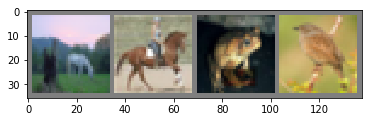

horse horse  frog  bird


In [8]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
dataiter = iter(trainloader) # randomly select images
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4))) # classes[labels[j]] for j in range(4) => generator

## 2. Define a Convolutional Neural Network


In [19]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # (input channel, output channel, kernel size)
        self.pool = nn.MaxPool2d(2, 2) # (2x2) window
        self.conv2 = nn.Conv2d(6, 16, 5) # (input channel, output channel, kernel size)
        self.fc1 = nn.Linear(16*5*5, 120) # map 16*16*5 features to 120 features
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
net = Net()

## 3. Define a Loss function and optimizer


In [20]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

In [21]:
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get inputs
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs) # forward
        loss = criterion(outputs, labels)
        loss.backward() # backward
        optimizer.step() # parameter update
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                 (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0
            
            
print('Finished Training')

[1,  2000] loss: 2.234
[1,  4000] loss: 1.890
[1,  6000] loss: 1.688
[1,  8000] loss: 1.574
[1, 10000] loss: 1.511
[1, 12000] loss: 1.462
[2,  2000] loss: 1.392
[2,  4000] loss: 1.387
[2,  6000] loss: 1.361
[2,  8000] loss: 1.314
[2, 10000] loss: 1.318
[2, 12000] loss: 1.276
Finished Training


## 5. Test the network on the test data


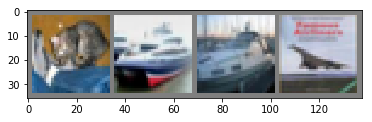

GroundTruth:    cat  ship  ship plane


In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# display images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [23]:
outputs = net(images)
_, predicted = torch.max(outputs, 1) # (value, index), specify dimension
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship   car  ship


Let us look at how the network performs on the whole dataset.



In [30]:
type(labels)
help(labels.size)
print(labels.size())

Help on built-in function size:

size(...) method of torch.Tensor instance
    size() -> torch.Size
    
    Returns the size of the :attr:`self` tensor. The returned value is a subclass of
    :class:`tuple`.
    
    Example::
    
        >>> torch.empty(3, 4, 5).size()
        torch.Size([3, 4, 5])

torch.Size([4])


In [34]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
       
    
print('Accuracy of the network on the 10000 test images: %d %%' % 
     (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


Hmmm, what are the classes that performed well, and the classes that did not perform well:



In [35]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
        

Accuracy of plane : 38 %
Accuracy of   car : 85 %
Accuracy of  bird : 49 %
Accuracy of   cat : 44 %
Accuracy of  deer : 42 %
Accuracy of   dog : 32 %
Accuracy of  frog : 57 %
Accuracy of horse : 53 %
Accuracy of  ship : 78 %
Accuracy of truck : 47 %
